In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    # automatic backpropagation
    # leaf node has no function (i.e. None)
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # repr = representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # handle non value cases
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # local derivative * global derivative
      # global derivative = derivative of final output with respect to out data 
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

      # set to += to composite gradients
      # when self and other are same object, = will override grad value
      # instead, we accumulate the gradients starting from base of 0

    out._backward = _backward
    return out
  
  def __radd__(self, other): # other + self
    return self + other
  
  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __rsub__(self, other): # other - self
    return other + (-self)
  
  def __neg__(self): # -self
    return self * -1
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other
  
  def __truediv__(self, other): # self / other
    # a / b
    # a * (1 / b)
    # a * (b ** -1)
    return self * other**-1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supports in/float powers"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # power rule * global grad
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward
    return out
  
  def tanh(self):
    # composite operation
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out
  
  def backward(self):
    # automatic backpropagation

    # sort graph into list
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # find backwards gradients in sorted order    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [37]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [38]:
# graphic representation to visualize expressions

from graphviz import Digraph

def trace(root):
  # builds set of all nodes and edges in graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any val in graph, create rectangular ('record') node for it
    dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if n is result of some operation, create op node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [39]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# squashing function
o = n.tanh(); o.label='o'
o.backward()

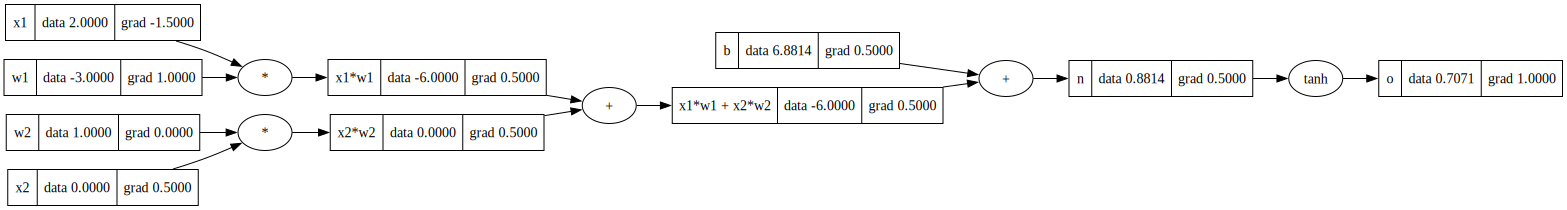

In [40]:
draw_dot(o)

In [41]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# BREAKING UP TANH
# o = n.tanh()
# ---------
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ---------

o.label='o'
o.backward()

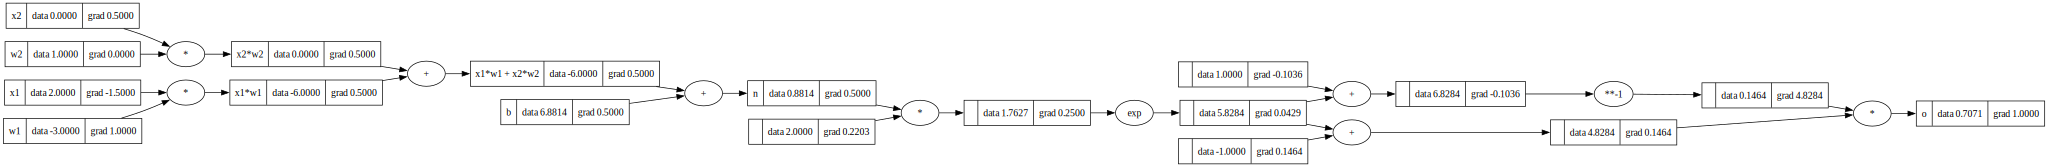

In [42]:
draw_dot(o)

In [43]:
# Let's do the same thing in pytorch

import torch

# Define directly in the constructor to keep them as leaf tensors
x1 = torch.tensor([2.0], dtype=torch.double, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.double, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.double, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.double, requires_grad=True)
b  = torch.tensor([6.8813735870195432], dtype=torch.double, requires_grad=True)

# Forward pass
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())

# Backward pass
o.backward()

# Print Results
print("----------")
assert x1.grad is not None
assert w1.grad is not None
assert x2.grad is not None
assert w2.grad is not None
print('x1 grad:', x1.grad.item())
print('w1 grad:', w1.grad.item())
print('x2 grad:', x2.grad.item())
print('w2 grad:', w2.grad.item())

0.7071067811865476
----------
x1 grad: -1.4999999999999996
w1 grad: 0.9999999999999998
x2 grad: 0.4999999999999999
w2 grad: 0.0


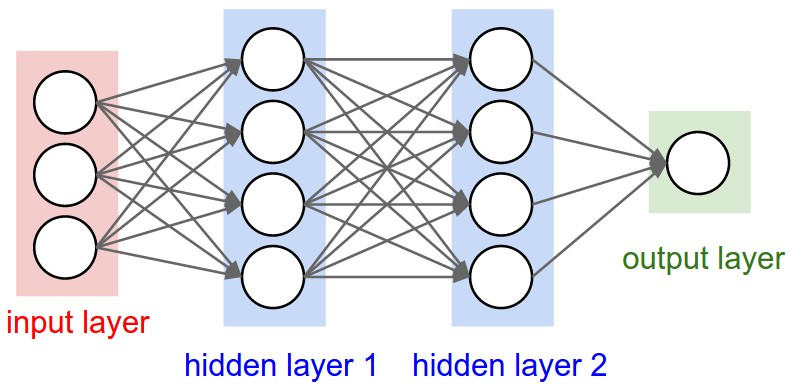

In [65]:
# Neuron implementation
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # sum(w * x) + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]


# A layer is a list of neurons that which all neurons connect to all inputs
# i.e. a set of nuerons evaluated independently
class Layer:

  def __init__(self, nin, nout):
    # nin = number of inputs from previous layer
    # nout = number of neurons in this layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    """
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params
    """
    # single list comprehension
    return [p for neuron in self.neurons for p in neuron.parameters()]


# MLP = Multi Layer Perceptron (image above)
class MLP:

  def __init__(self, nin, nouts):
    # nouts = list of nout
    sz = [nin] + nouts # number of neurons per layer
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    # calls these layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [66]:
# Forward pass of MLP
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 inputs, [2 layers of 4, 1 output]
n(x)

Value(data=0.8972736855348791)

In [67]:
n.parameters()

[Value(data=-0.10597177128253366),
 Value(data=-0.6850696773648293),
 Value(data=0.19919510033445875),
 Value(data=0.9480286593379927),
 Value(data=-0.3676022331937321),
 Value(data=-0.8775565539857524),
 Value(data=0.8504043575629248),
 Value(data=0.3613199270909624),
 Value(data=0.2118237665778151),
 Value(data=-0.28817224225719706),
 Value(data=0.8334900617656995),
 Value(data=0.03664965350967875),
 Value(data=-0.8196487774770722),
 Value(data=-0.08532119667994031),
 Value(data=0.5335551776956988),
 Value(data=0.376592176678747),
 Value(data=0.06113207107113183),
 Value(data=-0.29307357685098423),
 Value(data=0.1771609174127784),
 Value(data=0.721914540119984),
 Value(data=0.697431818986787),
 Value(data=0.5275897611499423),
 Value(data=0.9149952601681233),
 Value(data=-0.5977856367649901),
 Value(data=-0.07908074191783077),
 Value(data=0.8867374644555444),
 Value(data=0.25136790369223894),
 Value(data=-0.5906852394270012),
 Value(data=-0.6323306120264451),
 Value(data=0.22442955058

In [68]:
# Binary classifier neural net example
# aims for xs[0] input to give ys[0] output

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # inputs
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [92]:
# prediction
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8972736855348791),
 Value(data=0.3930454616028852),
 Value(data=0.8443852287245022),
 Value(data=0.9194939254898759)]

In [93]:
# How do we influence this neural net
# to adjust data values to move towards prediction?

# One universal weight measures performance of entire MLP
# called loss. Goal is to minimize loss.

# as loss approaches 0, predictions are more accurate to target
# yout - ygt ** 2 is only 0 when yout and ygt are equal

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # type: ignore
loss

Value(data=5.359366453746146)

In [ ]:
loss.backward() # type: ignore

In [84]:
print("data:", n.layers[0].neurons[0].w[0].data)
print("grad:", n.layers[0].neurons[0].w[0].grad)

data: -0.11017118614937904
grad: 0.20997074334226992


In [ ]:
# gradient = vector pointed towards increased loss
# gradient descent = modifying data by small step size towards gradient
# causes loss to move in direction opposite of gradient

for p in n.parameters():
  # when neuron grad is negative, increasing will cause loss to go down
  # when positive, decreasing will cause loss to go down
  p.data += -0.01 * p.grad

In [90]:
print("data:", n.layers[0].neurons[0].w[0].data)
print("grad:", n.layers[0].neurons[0].w[0].grad)

data: -0.10597177128253366
grad: 0.20997074334226992
